In [1]:
import glob
import rasterio
from pathlib import Path
import os
import reverse_geocoder as rg
import pyproj
import geopandas as gpd
import sys

In [2]:
if Path.cwd().name != 'src':
    os.chdir('/home/vaschetti/maxarSrc/src')
from my_functions import build

In [3]:
from my_functions import build
events_names = build.get_all_events()
for i, e_n in enumerate(events_names):
    print(i, e_n)

0 southafrica-flooding22
1 Kalehe-DRC-Flooding-5-8-23
2 shovi-georgia-landslide-8Aug23
3 Emilia-Romagna-Italy-flooding-may23
4 src
5 NWT-Canada-Aug-23
6 Libya-Floods-Sept-2023
7 Gambia-flooding-8-11-2022
8 New-Zealand-Flooding23
9 Hurricane-Fiona-9-19-2022
10 Hurricane-Idalia-Florida-Aug23
11 Hurricane-Ian-9-26-2022
12 yellowstone-flooding22
13 pakistan-flooding22
14 Morocco-Earthquake-Sept-2023
15 Indonesia-Earthquake22
16 cyclone-emnati22
17 Kahramanmaras-turkey-earthquake-23
18 test_folder
19 Marshall-Fire-21-Update
20 metadata
21 India-Floods-Oct-2023
22 Maui-Hawaii-fires-Aug-23
23 tonga-volcano21
24 BayofBengal-Cyclone-Mocha-May-23
25 Sudan-flooding-8-22-2022


In [4]:
bs = 10
config = build.SegmentConfig(batch_size = bs)

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [5]:
evento = build.Event(events_names[7], seg_config = config, when='pre')
print(evento.region_name)
all_mosaics_names = evento.all_mosaics_names
print(all_mosaics_names)
m0 = evento.mosaics[all_mosaics_names[0]]
print(f'Number of tiles: {m0.tiles_num}')


AfricaWest-Full
['10300100CFC9A500', '105001002BD68F00', '1040010073D77D00']
Number of tiles: 18


In [6]:
m0.set_build_gdf()

Found 3 links matching: [33303200, 3330320, 333032]


In [7]:
m0.proj_build_gdf

,type,properties,geometry
0,Feature,{'height': -1.0},"POLYGON ((307806.073 1481921.597, 307812.688 1..."
0,Feature,{'height': -1.0},"POLYGON ((358521.383 1539658.820, 358521.179 1..."
1,Feature,{'height': -1.0},"POLYGON ((327946.935 1539871.255, 327950.608 1..."
2,Feature,{'height': -1.0},"POLYGON ((327879.580 1539860.138, 327886.851 1..."
3,Feature,{'height': -1.0},"POLYGON ((327760.678 1539910.523, 327763.576 1..."
...,...,...,...
229046,Feature,{'height': -1.0},"POLYGON ((305208.972 1477522.933, 305217.298 1..."
229047,Feature,{'height': -1.0},"POLYGON ((305071.498 1469640.592, 305074.996 1..."
229048,Feature,{'height': -1.0},"POLYGON ((304910.511 1473693.484, 304920.082 1..."
229049,Feature,{'height': -1.0},"POLYGON ((304839.364 1474977.075, 304838.796 1..."


In [8]:
import rasterio
from rasterio.windows import Window
from my_functions import geoDatasets
from my_functions import samplers
from my_functions import segment
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from my_functions import samplers_utils
import torch

def segment_tile(self, tile_path):
        seg_config = self.event.seg_config

        dataset = geoDatasets.Maxar(str(tile_path))
        sampler = samplers.MyBatchGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
        dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

        canvas = np.zeros((seg_config.size, seg_config.size, 3), dtype=np.uint8)

        i = 0
        for batch in tqdm(dataloader):
            if i == 1:
                break
            original_img_tsr = batch['image']
            img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor

            #trees
            tree_boxes_b, num_trees4img = segment.get_GD_boxes(img_b, seg_config.GD_model,
                                                seg_config.TEXT_PROMPT,
                                                seg_config.BOX_TRESHOLD,
                                                seg_config.TEXT_TRESHOLD,
                                                dataset.res,
                                                max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
            
            #building            
            print(batch['bbox'])            
            building_boxes_b, num_build4img = segment.get_batch_buildings_boxes(batch['bbox'],
                                                                        proj_buildings_gdf = self.proj_build_gdf,
                                                                        dataset_res = dataset.res,
                                                                        ext_mt = 10)
            max_detect = max(num_trees4img + num_build4img)
            print(f'max_detect: {max_detect}')
            input_points, input_labels = build.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
            
            #boxes4FSam = build.get_boxes4FSam(tree_boxes_b, building_boxes_b, max_detect)
            print('tree_b shape: ', building_boxes_b[0].shape)
            print('input_points shape: ', input_points.shape)
            print('input_labels shape: ', input_labels.shape)

            all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                                   torch.from_numpy(input_points),
                                                   torch.from_numpy(input_labels),
                                                   efficient_sam = seg_config.efficient_sam)
            
            tree_mask_b, building_mask_b, pad_mask_b = segment.discern(all_masks_b, num_trees4img, num_build4img)
            
            road_mask_b = None
            i += 1
        return img_b, original_img_tsr, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b

img_b, original_img, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b = segment_tile(m0, m0.tiles_paths[17])

  0%|          | 0/337 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))


/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[BoundingBox(minx=315301.513671875, maxx=315484.619140625, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315393.06640625, maxx=315576.171875, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315484.619140625, maxx=315667.724609375, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315576.171875, maxx=315759.27734375, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315667.724609375, maxx=315850.830078125, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315759.27734375, maxx=315942.3828125, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315850.830078125, maxx=316033.935546875, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=315942.3828125, maxx=316125.488281

  0%|          | 1/337 [00:41<3:52:52, 41.58s/it]


In [11]:
print('all_mask: ', all_masks_b.shape)
print('tree_mask: ', tree_mask_b.shape)
print('building_mask: ', building_mask_b.shape)
print('pad_mask: ', pad_mask_b.shape)

all_mask:  (10, 103, 600, 600)
tree_mask:  (10, 600, 600)
building_mask:  (10, 600, 600)
pad_mask:  (10, 600, 600)


In [13]:
np_final_mask = np.greater_equal(all_masks_b, 0).any(axis=1)
np_final_mask.shape

(10, 600, 600)

In [22]:
from my_functions.plotting_utils import show_mask
import matplotlib.patches as patches
    
def plot_w_wo_masks_ESAM(img, masks, building_boxes = None, random_color = False):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask, ax2, random_color = random_color)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

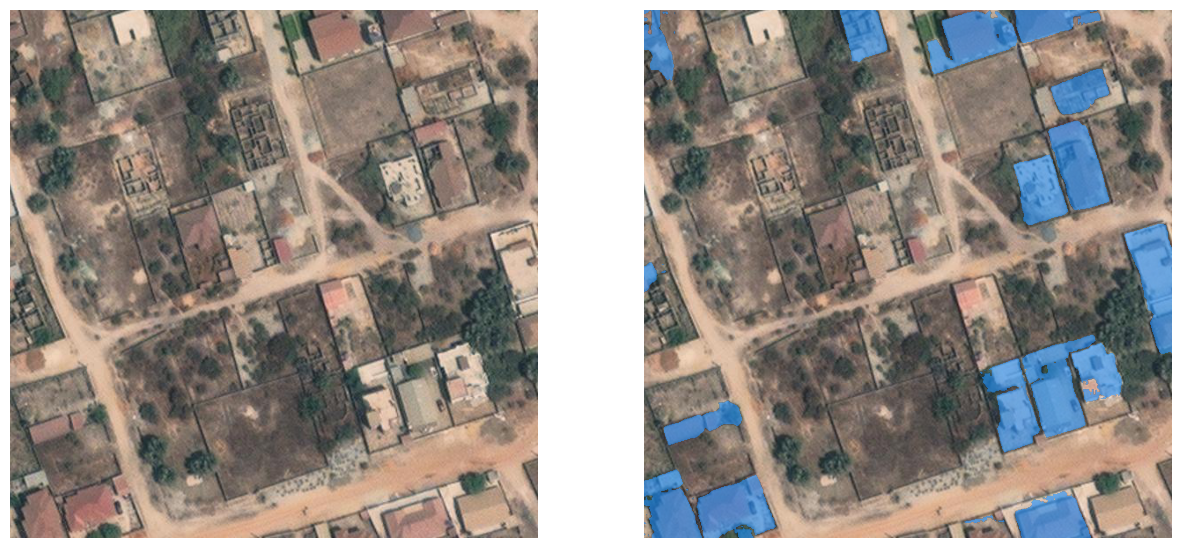

In [19]:
ix = 9
plot_w_wo_masks_ESAM(img_b[ix], building_mask_b[ix])

In [21]:
np.concatenate((tree_mask_b[ix], building_mask_b[ix])).shape

(1200, 600)

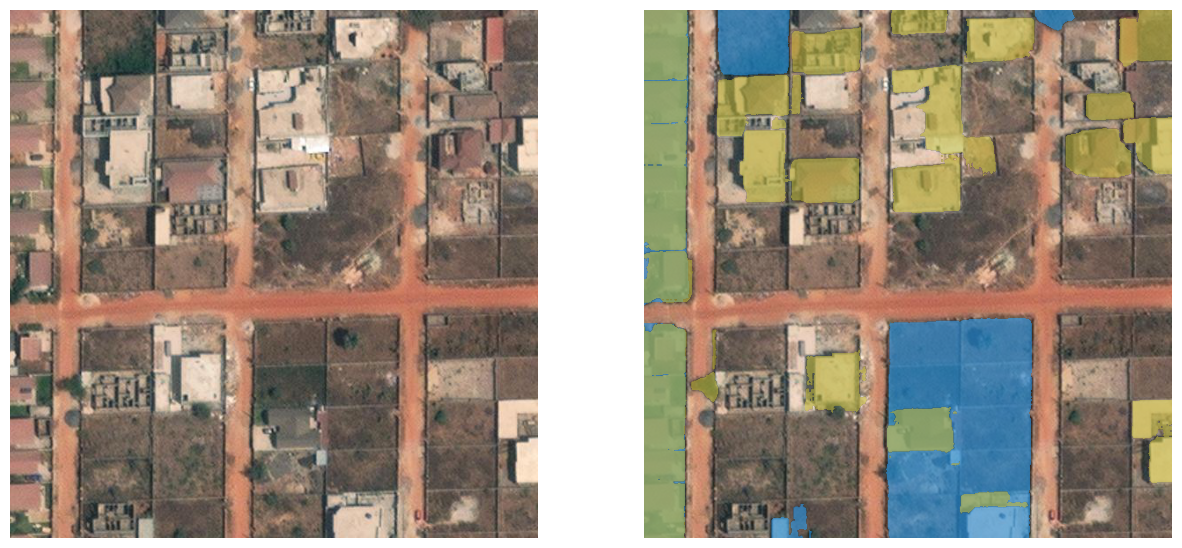

In [30]:
ix = 3
plot_w_wo_masks_ESAM(img_b[ix], np.concatenate((tree_mask_b[ix][None, ...], building_mask_b[ix][None, ...])), random_color=True)

In [18]:
original_img.shape

torch.Size([10, 3, 600, 600])

In [44]:
from torchvision import transforms
single_img_np = img_b[0]
print(single_img_np.shape)
a  = transforms.ToTensor()(single_img_np)
single_img_tsr = original_img[0]
b = single_img_tsr.div(255)
torch.equal(a, b)

(600, 600, 3)


True

In [48]:
torch.equal(original_img.div(255)[0], b)

True

In [32]:
single_img_np.shape

(600, 600, 3)

In [40]:
single_img_tsr = original_img[0]
single_img_tsr.div(255)

tensor([[[0.7098, 0.6510, 0.5412,  ..., 0.4902, 0.4863, 0.5059],
         [0.6980, 0.6235, 0.5059,  ..., 0.4549, 0.4667, 0.5020],
         [0.6980, 0.6078, 0.4863,  ..., 0.4510, 0.4706, 0.5137],
         ...,
         [0.5529, 0.5765, 0.5922,  ..., 0.7608, 0.7569, 0.7098],
         [0.5686, 0.5608, 0.5529,  ..., 0.7216, 0.7176, 0.7333],
         [0.4824, 0.4745, 0.4824,  ..., 0.6902, 0.6863, 0.7647]],

        [[0.6784, 0.6275, 0.5255,  ..., 0.4000, 0.4078, 0.4275],
         [0.6706, 0.6000, 0.4902,  ..., 0.3647, 0.3882, 0.4235],
         [0.6706, 0.5961, 0.4784,  ..., 0.3608, 0.3922, 0.4353],
         ...,
         [0.5020, 0.5255, 0.5529,  ..., 0.6510, 0.6471, 0.6000],
         [0.5294, 0.5176, 0.5176,  ..., 0.6118, 0.6078, 0.6235],
         [0.4392, 0.4392, 0.4471,  ..., 0.5804, 0.5765, 0.6549]],

        [[0.6275, 0.5804, 0.4824,  ..., 0.3686, 0.3804, 0.4000],
         [0.6078, 0.5529, 0.4471,  ..., 0.3333, 0.3608, 0.3961],
         [0.6078, 0.5373, 0.4275,  ..., 0.3373, 0.3647, 0.

In [38]:
import torch
torch.from_numpy(single_img_np.transpose((2, 0, 1))).contiguous()


tensor([[[181, 166, 138,  ..., 125, 124, 129],
         [178, 159, 129,  ..., 116, 119, 128],
         [178, 155, 124,  ..., 115, 120, 131],
         ...,
         [141, 147, 151,  ..., 194, 193, 181],
         [145, 143, 141,  ..., 184, 183, 187],
         [123, 121, 123,  ..., 176, 175, 195]],

        [[173, 160, 134,  ..., 102, 104, 109],
         [171, 153, 125,  ...,  93,  99, 108],
         [171, 152, 122,  ...,  92, 100, 111],
         ...,
         [128, 134, 141,  ..., 166, 165, 153],
         [135, 132, 132,  ..., 156, 155, 159],
         [112, 112, 114,  ..., 148, 147, 167]],

        [[160, 148, 123,  ...,  94,  97, 102],
         [155, 141, 114,  ...,  85,  92, 101],
         [155, 137, 109,  ...,  86,  93, 104],
         ...,
         [120, 126, 132,  ..., 144, 143, 131],
         [126, 126, 125,  ..., 134, 133, 135],
         [106, 105, 107,  ..., 126, 125, 143]]], dtype=torch.uint8)

In [19]:
from torchvision import transforms
transforms.ToTensor()(original_img)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [12]:
import rasterio

with rasterio.open('/mnt/data2/vaschetti_data/maxar/Indonesia-Earthquake22/post/10300100DD6AE200/300020121231.tif') as src:
    print(src.profile)
    print(src.transform * (0,0))
    print(type(src.read()))

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 17408, 'height': 17408, 'count': 3, 'crs': CRS.from_epsg(32748), 'transform': Affine(0.30517578125, 0.0, 714843.75,
       0.0, -0.30517578125, 9250156.25), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'jpeg', 'interleave': 'pixel', 'photometric': 'ycbcr'}
(714843.75, 9250156.25)
<class 'numpy.ndarray'>


In [27]:
import torch
torch.tensor([torch.tensor([1,23]), torch.tensor([1,23])])

TypeError: only integer tensors of a single element can be converted to an index

In [42]:
a = np.array([[2,3,5,6]]*5)
print('a', a.shape)
b = np.expand_dims(a, 0)
print('b', b.shape)
b.reshape(-1,2,2).shape
lbs = np.array([[2,3]]*a.shape[0]) #(query_img_x, 2)
print('lbs', lbs.shape)

lbs_pad_value = 0
pad_len = 3
pad_width = ((0,pad_len),(0, 0))
padded_lbs = np.pad(lbs, pad_width, constant_values = lbs_pad_value)
print('padded_lbs', padded_lbs.shape)

#

#np.expand_dims(np.array([[2,3]]*89), 0).reshape(-1,2,2).shape

a (5, 4)
b (1, 5, 4)
lbs (5, 2)
padded_lbs (8, 2)


In [11]:
max_detect = 0
for tree_detec, build_detec in zip(tree_boxes_b, building_boxes_b):
    tree_build_detect = np.concatenate((tree_detec, build_detec))
    print(tree_build_detect.shape)
    if tree_build_detect.shape[0] > max_detect:
        max_detect = tree_build_detect.shape[0]
print(max_detect)

(73, 4)
(81, 4)
(67, 4)
(32, 4)
(22, 4)
(37, 4)
(60, 4)
(64, 4)
(76, 4)
(97, 4)
97


In [12]:
tree_build_detect[-2:]

array([[ 46.02955093, -64.9986882 , 137.95377605,  18.32582591],
       [-18.68889474, -55.42104143,  77.42522355,  33.31492634]])

In [13]:
boxes4FSam[9][-2:]

array([[ 46.02955093, -64.9986882 , 137.95377605,  18.32582591],
       [-18.68889474, -55.42104143,  77.42522355,  33.31492634]])

In [16]:
tree_boxes_b.shape

AttributeError: 'list' object has no attribute 'shape'

In [22]:
building_boxes_b[0]

array([[309.98570239, 531.16756378, 400.05775565, 599.11843045],
       [197.18709013, 521.998085  , 291.94627115, 607.62060479],
       [442.3468652 , 440.38028282, 509.7256299 , 491.80168273],
       [508.34676577, 429.38595185, 574.24936357, 497.80642913],
       [191.35552874, 408.18006026, 249.97579195, 466.04311942],
       [134.12823805, 404.33616891, 209.29511258, 492.55903943],
       [ 83.56970608, 382.57891312, 149.64938268, 439.34506389],
       [177.87148762, 367.25898458, 253.49672324, 443.2308245 ],
       [138.70563535, 364.96727305, 204.31381601, 418.62759761],
       [113.38519513, 150.85367569, 199.30431534, 242.26098925],
       [158.73135921, 132.70222472, 245.43771372, 238.92580195],
       [161.21491754,  60.78454258, 218.22764666, 126.22357929],
       [ 32.77999974, -51.79608738, 131.72194653,  80.71851724],
       [113.57644788, -27.7877902 , 209.07287937,  54.65532637],
       [267.85264123, 324.01547511, 349.90460727, 399.31619512],
       [269.5459774 , 312

In [48]:

#pad_len = max_detect - building_boxes_b[0].shape[0]
pad_len = 4
pad_width = ((0,pad_len),(0, 0))
np.pad(building_boxes_b[0], pad_width, constant_values=0)

array([[309.98570239, 531.16756378, 400.05775565, 599.11843045],
       [197.18709013, 521.998085  , 291.94627115, 607.62060479],
       [442.3468652 , 440.38028282, 509.7256299 , 491.80168273],
       [508.34676577, 429.38595185, 574.24936357, 497.80642913],
       [191.35552874, 408.18006026, 249.97579195, 466.04311942],
       [134.12823805, 404.33616891, 209.29511258, 492.55903943],
       [ 83.56970608, 382.57891312, 149.64938268, 439.34506389],
       [177.87148762, 367.25898458, 253.49672324, 443.2308245 ],
       [138.70563535, 364.96727305, 204.31381601, 418.62759761],
       [113.38519513, 150.85367569, 199.30431534, 242.26098925],
       [158.73135921, 132.70222472, 245.43771372, 238.92580195],
       [161.21491754,  60.78454258, 218.22764666, 126.22357929],
       [ 32.77999974, -51.79608738, 131.72194653,  80.71851724],
       [113.57644788, -27.7877902 , 209.07287937,  54.65532637],
       [267.85264123, 324.01547511, 349.90460727, 399.31619512],
       [269.5459774 , 312

In [50]:
a = np.array([[1,2,3],[4,5,6]])
b = [a]
np.array(b)

array([[[1, 2, 3],
        [4, 5, 6]]])

In [44]:
pad_width = ((0,1),(0, 0))
pad_width = (1,1)
pad_value = (1,2)
np.pad(a, pad_width, constant_values = pad_value)

array([[1, 1, 1, 1, 2],
       [1, 1, 2, 3, 2],
       [1, 4, 5, 6, 2],
       [1, 2, 2, 2, 2]])

In [23]:
pad_width = (0, 2)
pad_value = [0,0,0,0]
np.pad(building_boxes_b[0], pad_width, constant_values=pad_value)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,)  and requested shape (2,2)

In [19]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.concatenate((a,b))
a+b

array([5, 7, 9])

In [10]:
tree_boxes_b[0]

array([[ 3.23300781e+02,  2.24048996e+02,  3.60353455e+02,
         2.68084229e+02],
       [ 2.76522797e+02,  3.87285034e+02,  3.16694183e+02,
         4.42911133e+02],
       [ 4.50218140e+02,  1.94079758e+02,  4.84834534e+02,
         2.27122147e+02],
       [ 3.69578094e+02,  3.18432098e+02,  4.27074432e+02,
         3.86913483e+02],
       [ 5.66433594e+02,  1.11326767e+02,  5.99909912e+02,
         1.44977280e+02],
       [ 2.09681564e+02,  2.91909912e+02,  2.84170685e+02,
         4.56198853e+02],
       [ 2.83904510e+02,  7.75468979e+01,  3.12861481e+02,
         1.20225838e+02],
       [ 2.09022415e+02,  5.22820435e+02,  2.43402573e+02,
         5.51473022e+02],
       [ 2.33838867e+02,  1.04958504e+02,  2.71692230e+02,
         1.56647797e+02],
       [ 3.25792816e+02,  6.39679337e+01,  3.75214020e+02,
         1.11246132e+02],
       [ 2.47726517e+02,  1.56724869e+02,  2.91023621e+02,
         2.05911819e+02],
       [ 3.28284668e+02,  6.43150635e+01,  3.65025940e+02,
      

In [11]:
building_boxes_b[0]

array([[309.98570239, 531.16756378, 400.05775565, 599.11843045],
       [197.18709013, 521.998085  , 291.94627115, 607.62060479],
       [442.3468652 , 440.38028282, 509.7256299 , 491.80168273],
       [508.34676577, 429.38595185, 574.24936357, 497.80642913],
       [191.35552874, 408.18006026, 249.97579195, 466.04311942],
       [134.12823805, 404.33616891, 209.29511258, 492.55903943],
       [ 83.56970608, 382.57891312, 149.64938268, 439.34506389],
       [177.87148762, 367.25898458, 253.49672324, 443.2308245 ],
       [138.70563535, 364.96727305, 204.31381601, 418.62759761],
       [113.38519513, 150.85367569, 199.30431534, 242.26098925],
       [158.73135921, 132.70222472, 245.43771372, 238.92580195],
       [161.21491754,  60.78454258, 218.22764666, 126.22357929],
       [ 32.77999974, -51.79608738, 131.72194653,  80.71851724],
       [113.57644788, -27.7877902 , 209.07287937,  54.65532637],
       [267.85264123, 324.01547511, 349.90460727, 399.31619512],
       [269.5459774 , 312

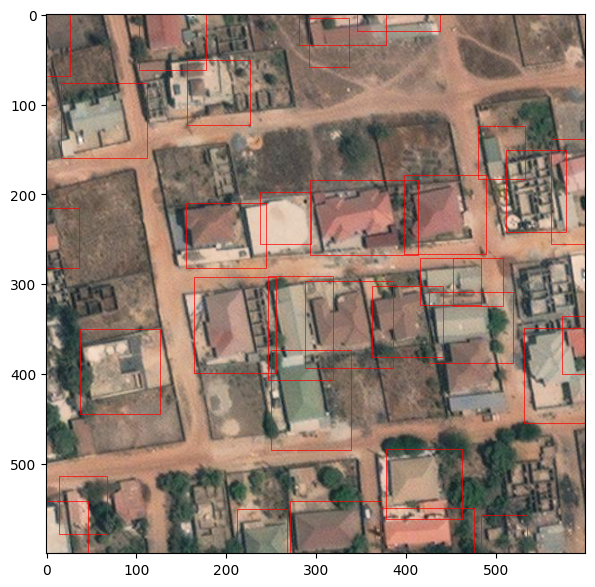

In [47]:
from my_functions.plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ix = 8
ax.imshow(img_b[ix])
#show_box(tree_boxes_b[ix].tolist(), ax, color='b')
show_box(building_boxes_b[ix], ax, color='r')
plt.show()

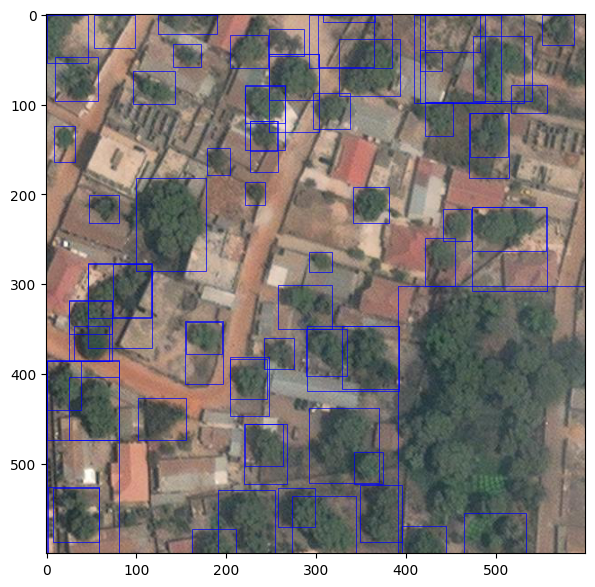

In [39]:
from my_functions.plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ix = 9
ax.imshow(img_b[ix])
show_box(tree_boxes_b[ix].tolist(), ax, color='b')

In [6]:
import rasterio
from rasterio.windows import Window
from my_functions import geoDatasets
from my_functions.samplers import MyGridGeoSampler, MyBatchGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import matplotlib.pyplot as plt
from tqdm import tqdm

def segment_tile(self, tile_path):
    batch_size = 4
    dataset = geoDatasets.Maxar(str(tile_path))
    sampler = MyBatchGridGeoSampler(dataset, batch_size=batch_size, size=100, stride=100)
    print(len(sampler))
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)
    print(len(dataloader))
    print(dataset.res)
    for batch in tqdm(dataloader):
        #print(batch.keys())
        #samples_list = unbind_samples(batch)
        #print(samples_list)
        #img_batch = batch['image']
        #print(type(img_batch))
        
        #Le immagini sono già RGB
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8')
        #fig, axs = plt.subplots(1, batch_size, figsize=(30, 30))
        #for i in range(batch_size):
        #    axs[i].imshow(img_b[i])
        #print(img_b.shape)
        break
    return img_b

img_b = segment_tile(evento, m0.tiles_paths[0])

7657
7657
0.30517578125


  0%|          | 0/7657 [00:00<?, ?it/s]

  0%|          | 0/7657 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315457.45849609375 1490156.25, 320156.25 1490156.25, 320156.25 1484843.75, 315425.4150390625 1484843.75, 315457.45849609375 1490156.25))


In [42]:
m0.dataset_res

AttributeError: 'Mosaic' object has no attribute 'dataset_res'

In [25]:
img_b.shape

(4, 100, 100, 3)

In [49]:
import numpy as np
from my_functions import segment
from groundingdino.util.inference import predict as GD_predict
from groundingdino.util.inference import load_model as GD_load_model

def get_gdino_boxes(img_batch: np.array,
                    GDINO_model,
                    TEXT_PROMPT,
                    BOX_TRESHOLD,
                    TEXT_TRESHOLD,
                    dataset_res,
                    max_area_mt2 =3000):
    all_tree_boxes4Sam = []
    for img in img_batch:
        image_transformed = segment.dino_img_load(img)
        tree_boxes, logits, phrases = GD_predict(GDINO_model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
        tree_boxes4Sam = []
        if len(tree_boxes) != 0:
            sample_size = image_transformed.shape[-1]
            keep_ix_tree_boxes = segment.filter_on_box_area_mt2(tree_boxes, sample_size, dataset_res, max_area_mt2 = max_area_mt2)
            tree_boxes4Sam = segment.GDboxes2SamBoxes(tree_boxes[keep_ix_tree_boxes], sample_size)
            all_tree_boxes4Sam.append(tree_boxes4Sam)
    return all_tree_boxes4Sam

In [46]:
GDINO_root ="/home/vaschetti/maxarSrc/models/GDINO"
CONFIG_PATH = os.path.join(GDINO_root, "GroundingDINO_SwinT_OGC.py")
WEIGHTS_PATH = os.path.join(GDINO_root, "groundingdino_swint_ogc.pth")
GDINO_model = GD_load_model(CONFIG_PATH, WEIGHTS_PATH, device = 'cuda')
TEXT_PROMPT = 'green tree' #'house' or 'tree' or 'green tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30

final text_encoder_type: bert-base-uncased


In [50]:
dataset_res = 0.30517578125
get_gdino_boxes(img_b, GDINO_model, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD, dataset_res)

[array([], shape=(0, 4), dtype=float32),
 array([[-2.2872925e-02,  5.3925256e+02,  4.5824928e+01,  7.9989490e+02],
        [ 1.2340546e-03,  6.8161597e+02,  4.5057930e+01,  8.0044031e+02],
        [ 5.3577423e-03,  4.6948584e+02,  4.5699699e+01,  8.0025452e+02],
        [ 8.8871002e-02,  5.3001917e+02,  7.0290146e+01,  8.0000415e+02],
        [ 2.9214859e-02,  6.1865063e+02,  4.5522621e+01,  8.0009668e+02]],
       dtype=float32),
 array([[729.7648 , 692.86084, 800.00305, 800.07495],
        [729.84216, 611.34766, 799.9595 , 800.01465],
        [730.4532 , 642.9078 , 799.9239 , 800.23785]], dtype=float32),
 array([], shape=(0, 4), dtype=float32)]

In [34]:
import groundingdino.datasets.transforms as T
import numpy as np
import torch
from PIL import Image

def batch_GD_img_load(batch_np_img_rgb: np.array)-> torch.Tensor:
    """
    Transform the image from np.array to torch.Tensor and normalize it.
    """
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    for i, np_img_rgb in enumerate(batch_np_img_rgb):
        image_pillow = Image.fromarray(np_img_rgb)
        image_transformed, _ = transform(image_pillow, None)
        if i == 0:
            batch_images_transformed = image_transformed.unsqueeze(0)
        else:
            batch_images_transformed = torch.cat((batch_images_transformed, image_transformed.unsqueeze(0)), dim=0)
    return batch_images_transformed

def dino_img_load(np_img_rgb: np.array)-> torch.Tensor:
    """
    Transform the image from np.array to torch.Tensor and normalize it.
    """
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_pillow = Image.fromarray(np_img_rgb)
    image_transformed, _ = transform(image_pillow, None)
    return image_transformed

def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    print(image_pil.getbands())

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

In [32]:
image, image_transformed = load_image('/home/vaschetti/maxarSrc/exampleData/10300100C2D81700-visual_small.tif')

In [18]:
img_path = '/home/vaschetti/maxarSrc/exampleData/10300100C2D81700-visual.tif'
image_pil, image = load_image(img_path)

In [25]:
image_pil.getbands()

('R', 'G', 'B')

In [16]:
type(Image.open(img_path).convert("RGB"))

PIL.Image.Image

In [22]:
image

tensor([[[-1.0562, -0.9534, -0.9363,  ..., -0.1828,  0.1083,  0.0741],
         [-1.2103, -1.1075, -1.0904,  ..., -0.3027, -0.0287, -0.0629],
         [-1.3815, -1.3130, -1.2274,  ..., -0.3883, -0.1143, -0.1143],
         ...,
         [-1.8610, -1.7240, -1.9295,  ..., -0.9534, -1.0390, -1.1075],
         [-1.7925, -1.6384, -1.7240,  ..., -0.9363, -0.9534, -0.9705],
         [-1.8268, -1.6555, -1.5870,  ..., -0.8335, -0.6623, -0.6452]],

        [[-0.8803, -0.7752, -0.7577,  ..., -0.1800, -0.0749, -0.1099],
         [-1.0553, -0.9328, -0.8803,  ..., -0.2675, -0.1975, -0.2150],
         [-1.2304, -1.1429, -1.0203,  ..., -0.3375, -0.2500, -0.2500],
         ...,
         [-1.7206, -1.6155, -1.8256,  ..., -0.9678, -1.1429, -1.1954],
         [-1.6155, -1.4755, -1.6155,  ..., -0.9503, -1.0553, -1.0728],
         [-1.6331, -1.4755, -1.4755,  ..., -0.8452, -0.7577, -0.7402]],

        [[-0.9156, -0.8110, -0.7936,  ..., -0.5495, -0.5147, -0.5147],
         [-1.0376, -0.9678, -0.9330,  ..., -0

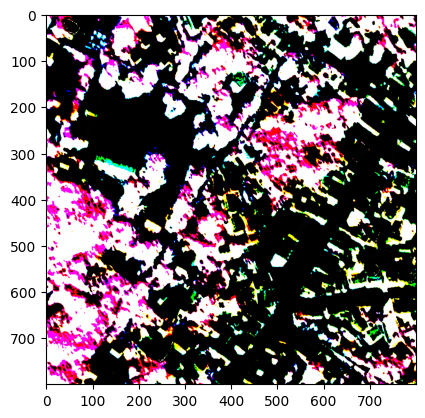

In [23]:
plt.imshow(image.permute(1,2,0).numpy().astype('uint8'))